In [2]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from scipy.stats import linregress
from shapely.geometry import Polygon
from scipy.special import erf

### Define functions

In [84]:
def PolyArea(x,y):
    """Returns area of a polygon given the x,y-coordinates of its points

    Args:
        x (np.array): x-coordinates
        y (np.array): y-coordinates

    Returns:
        _type_: _description_
    """    
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def Kell_rho(T):
    """Returns density of water at temperature T according to the Kell function (5th order polynomial fit)

    Args:
        T (float): temperature [degC]

    Returns:
        float: density of water [kg/m3]
    """    
    a = -2.8054253e-10
    b = 1.0556302e-7
    c = -4.6170461e-5
    d = -0.0079870401
    e = 16.945176
    f = 999.83952
    g = 0.01687985
    rho = (((((a*T+b)*T+c)*T+d)*T+e)*T+f) / (1+g*T)
    return rho

def Ra(r,T1,T2):
    """Calculates Rayleigh number for a cylinder in water, given radius and two temperatures. The density is calculated according to the Kell's formula.

    Args:
        r (float): cylinder's radius [m]
        T1 (float): temperature 1 [degC]
        T2 (float): temperature 2 [degC]

    Returns:
        float: Rayleigh number
    """    
    Tavg = np.mean([T1,T2])
    rho = Kell_rho(Tavg)
    deltaRho = abs(Kell_rho(T1)-Kell_rho(T2))
    return g*deltaRho*8*r**3/(alpha*nu*rho)

def Nu(Ray):
    """Calculates Nusselt number for a cylinder in water given Rayleigh number and Prandtl number (not function variable). Formula from Churchill and Chu, 1975

    Args:
        Ray (float): Rayleigh number

    Returns:
        float: Nusselt number
    """    
    return (0.6 + (0.387*Ray**(1/6)) / ( ( 1 + (0.559/Pr)**(9/16) ) ** (16/9) ) )**2 

def h(Nu,r):   
    return kappa*Nu/(2*r)

def drdt(h,r,t):
    T_0 = -T_in
    T_star = T_0 + (deltaT-T_0)*.5*erf(r/np.sqrt(alpha*t))
    dT_stardt = (deltaT-T_0)*.5 * np.exp(-r**2/(alpha*t)) / np.sqrt(alpha*t)
    return -(h*deltaT+kappa*dT_stardt)/(rho_ice*(L_f+c_s*(-T_star)))

def evolution(r_0):
    timesteps = 1600 #s
    radii = [r_0,]
    r = r_0
    for timestep in range(1,timesteps):
        # timestep is in seconds
        Ra_ = Ra(r,-16,20)
        Nu_ = Nu(Ra_)
        h_ = h(Nu_,r)
        drdt_ = drdt(h_,r,timestep)
        # print(Ra_,Nu_,h_,drdt_)
        r = r + drdt_
        radii.append(r)
    return radii

def makePolygonBelow(polygon, level):
    """Draws the part of a polygon which is below a horizontal level. Returns a list of coordinates. 

    Args:
        polygon (np.array): polygon coordinates
        level (float): horizontal level 

    Returns:
        np.array: coordinates of polygon below level
    """    
    newY = np.where(polygon[:,1]<level,polygon[:,1],level)
    polygonBELOW = polygon.copy()
    polygonBELOW[:,1] = newY
    return polygonBELOW



def findWL(polygon, densityRatio=.917, epsilon = 0.001):
    """Finds the water level for an ice polygon immersed in water, with prescribed precision. 

    Args:
        polygon (np.array): polygon coordinates
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.
        epsilon (float, optional): precisio of calculation. Defaults to 0.001.

    Returns:
        float: water level of the immersed polygon
    """    
    originalArea = PolyArea(polygon[:,0],polygon[:,1])
    ymin, ymax = min(polygon[:,1]),max(polygon[:,1])
    mmin, mmax = ymin,ymax
    attempt = ymin + (ymax-ymin) * densityRatio 
    pgbelow = makePolygonBelow(polygon,attempt)
    # plt.plot(pgbelow[:,0],pgbelow[:,1],label='initial attempt')

    newArea = PolyArea(pgbelow[:,0],pgbelow[:,1])

    ratio = newArea/originalArea

    while abs(ratio-densityRatio) > epsilon:
        if ratio-densityRatio > 0:
            mmax = attempt
        else:
            mmin = attempt
        attempt = (mmin+mmax)/2
        pgbelow_ = makePolygonBelow(polygon,attempt)
        newArea_ = PolyArea(pgbelow_[:,0],pgbelow_[:,1])
        ratio = newArea_/originalArea
        # print(f'{newArea_:.2f}',ratio)

    return attempt

def hydrostasy(contour,densityRatio=.917):
    """Returns center of mass and center of buoyancy for an immersed polygon.

    Args:
        contour (np.array): coordinates of polygon.
        densityRatio (float, optional): density ratio of the two fluids. Defaults to .917, ratio of ice/fresh water.

    Returns:
        tuple: (center of mass, center of buoyancy)
    """    
    polygon = Polygon(contour)
    com = polygon.centroid
    del polygon
    immersedPG = makePolygonBelow(contour,findWL(contour,densityRatio=densityRatio))
    polygon = Polygon(immersedPG)
    cob = polygon.centroid
    return com,cob

# Load one contour

1206931.0274004936 px2


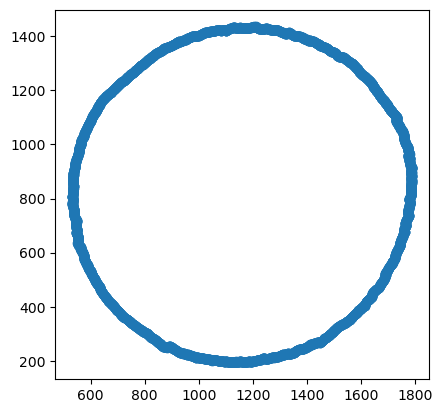

In [6]:
oo = np.genfromtxt('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-12/1st/contours/01.csv',dtype='float',delimiter=',')
oo.shape
plt.figure()
plt.scatter(oo[:,1],oo[:,0])
plt.gca().set_aspect('equal')



print(PolyArea(oo[:,1],oo[:,0]),'px2')

# Theoretical expectations

In [70]:
g = 9.81 # m/s2, gravity
beta = 1e-4 # degC-1, thermal coefficient expansion water
deltaT = 20.5 # degC, melting-ambient
alpha = 0.133e-6 # m2/s, thermal diffiusivity water
#alpha = 1.02e-6 # m2/s, thermal diffiusivity ice
nu = 1.4e-6 # m2/s, kinematic viscosity water
Pr = 10 # variable
kappa = 580e-3 # W/Km, thermal conductivity water
T_in = 16 # degC, initial negative temperature ice
rho_ice = 917 # kg/m3, density ice
L_f = 334e3 # J/kg, latent heat fusion water
c_s = 4186 # J/kgK, specific heat water 



In [71]:
Kell_rho(4)

999.9719941255903

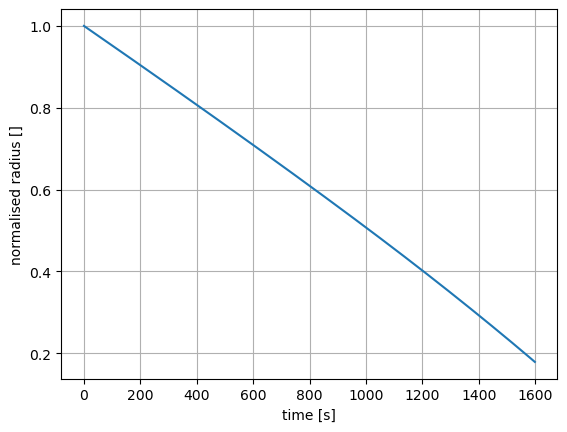

In [72]:
#evolution(0.05)
plt.figure()
plt.plot(np.array(evolution(0.0405))/evolution(0.0405)[0])
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('normalised radius []')

plt.show()

# Load all contours and compare theory and exp

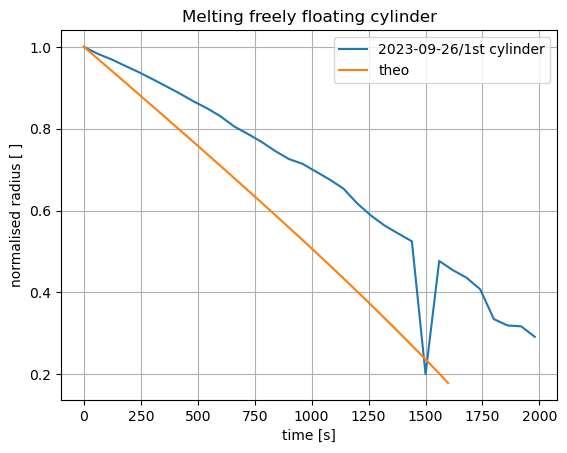

In [74]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-26/1st']

plt.figure()

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for contourPATH in contoursPATH:
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
        radii.append(radius)

    plt.plot(60*np.arange(len(radii)),radii/radii[0],label=cylinder+' cylinder') # one contour every 30 seconds

plt.plot(np.array(evolution(0.0405))/evolution(0.0405)[0],label='theo')

#slope, _, _,_ = np.linalg.lstsq(30*np.arange(len(radii))[:,np.newaxis],
#                                radii/radii[0])
# plt.plot(30*np.arange(len(radii)),
#         1-slope * 30*np.arange(len(radii)), 
#         label='linear')

# plt.yscale('log')
# plt.xscale('log')
# plt.ylim(3e-1,1.01e0)

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('normalised radius [ ]')
plt.title('Melting freely floating cylinder')
plt.show()

# Plot all contours

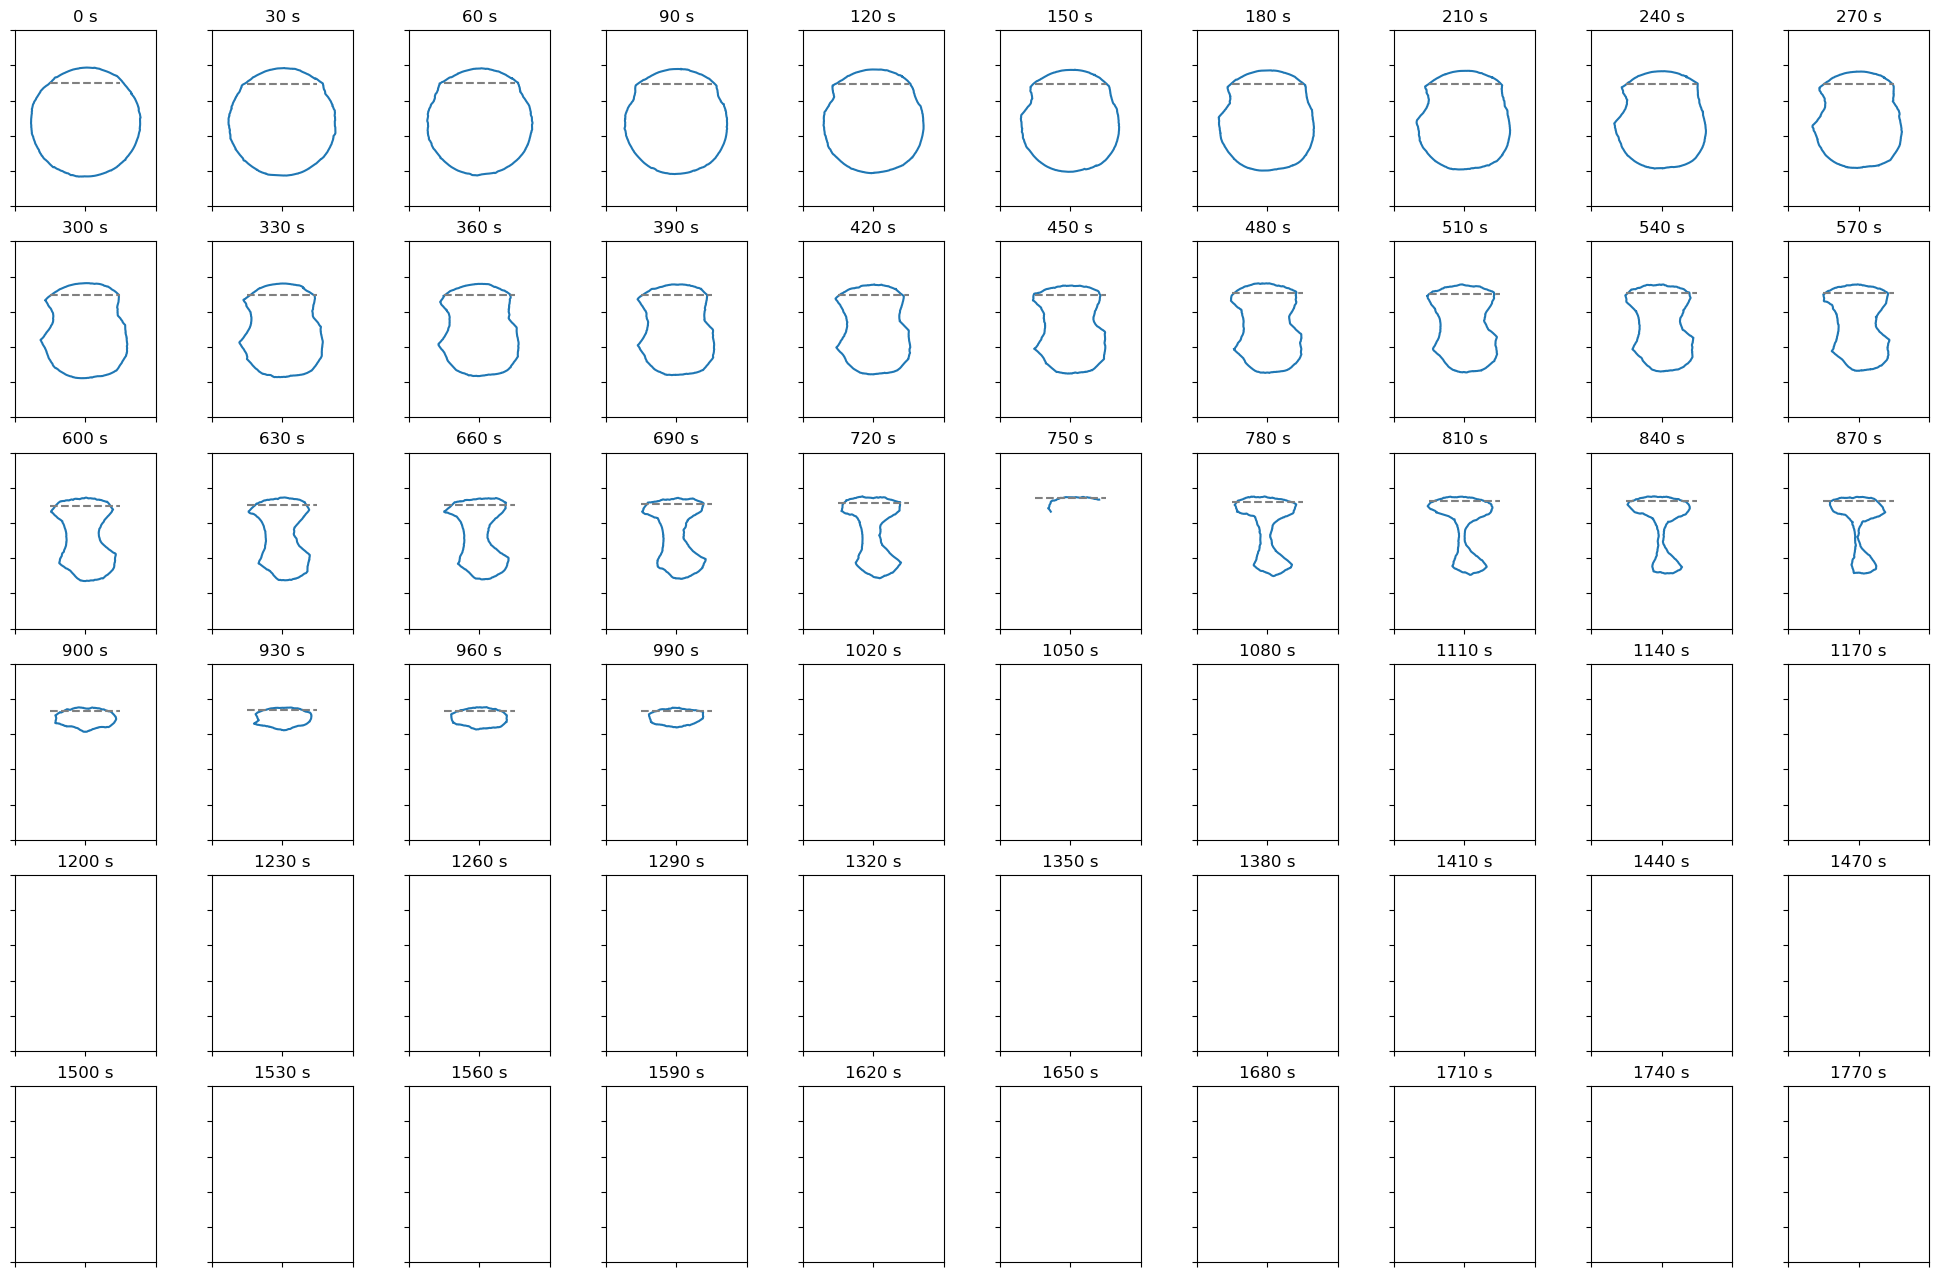

In [87]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-26/'
cylinders = ['1st']

fig, ax = plt.subplots(nrows=6,ncols=10,figsize=(25,16))

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        contour[:,1 ] = -contour[:,1] + 4000 # straighten y direction
        xcenter = np.mean(contour,axis=0)[0]
        
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1])

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].hlines(wl,-1000,1000,linestyles='--',colors='grey')

for it,axi in enumerate(ax.flatten()):
    axi.set_aspect('equal')
    axi.set_xticklabels('')
    axi.set_yticklabels('')
    axi.set_title(f'{it*30} s')
    axi.set_ylim(0,5000)
    axi.set_xlim(-2000,2000)

plt.show()

# Find waterline

### Test on one contour

NameError: name 'PolyArea' is not defined

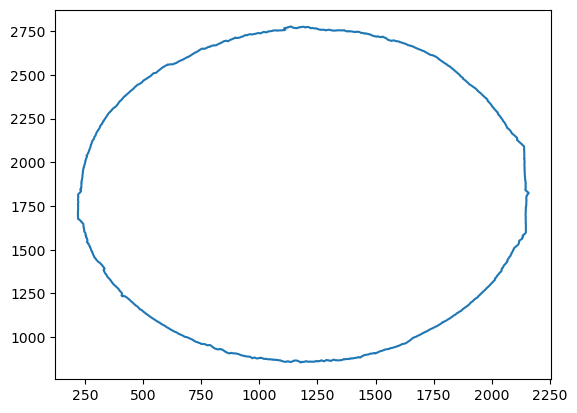

In [7]:
plt.figure()
contour = np.genfromtxt(contoursPATH[1],dtype='float',delimiter=',').T
contour[:,1 ] = -contour[:,1] + 3000 # straighten y direction

plt.plot(contour[:,0],contour[:,1],label='orig')



immersedPG = makePolygonBelow(contour,findWL(contour))
plt.plot(immersedPG[:,0],immersedPG[:,1],label='immersed')


plt.legend()
plt.gca().set_aspect('equal')
plt.show()

### Apply to all contours

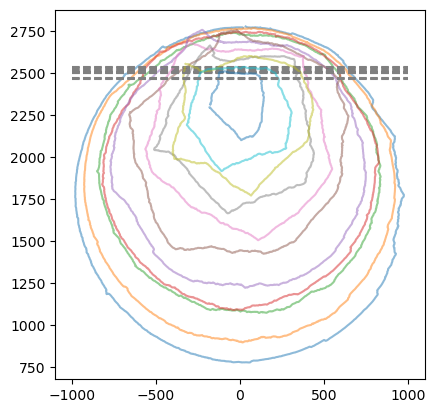

In [71]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-14/'
cylinders = ['1st']

plt.figure()

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for contourPATH in contoursPATH[::5]:
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',').T
        
        contour[:,1 ] = -contour[:,1] + 3000 # straighten y direction
        # plt.plot(contour[:,0],contour[:,1])
        xcenter = np.mean(contour,axis=0)[0]
        # plt.scatter(np.mean(contour,axis=0)[0],np.mean(contour,axis=0)[1])
        plt.plot(contour[:,0]-xcenter,contour[:,1],alpha=.5)

        wl = findWL(contour)
        plt.hlines(wl,-1000,1000,linestyles='--',colors='grey')


plt.gca().set_aspect('equal')

plt.show()

## Find CoM

### Test on one contour

x-location difference CoM-CoB = 2.20 px


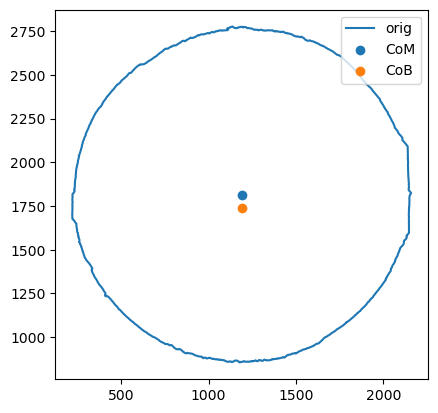

In [12]:
plt.figure()
contour = np.genfromtxt(contoursPATH[1],dtype='float',delimiter=',').T
contour[:,1 ] = -contour[:,1] + 3000 # straighten y direction

plt.plot(contour[:,0],contour[:,1],label='orig')



com,cob = hydrostasy(contour)

plt.scatter(com.x,com.y,label='CoM')
plt.scatter(cob.x,cob.y,label='CoB')
print(f'x-location difference CoM-CoB = {com.x-cob.x:.2f} px')

plt.legend(loc='upper right')
plt.gca().set_aspect('equal')
plt.show()

### Check rotations of contour

x-location difference CoM-CoB = -0.36 px


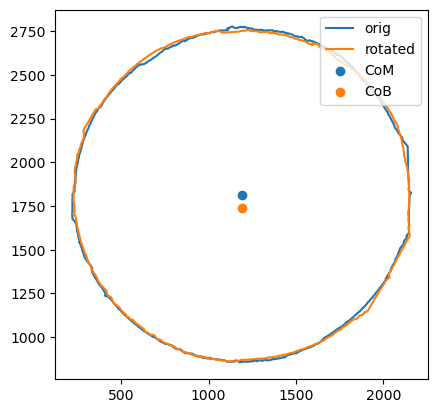

Stability index = 156.0 degrees


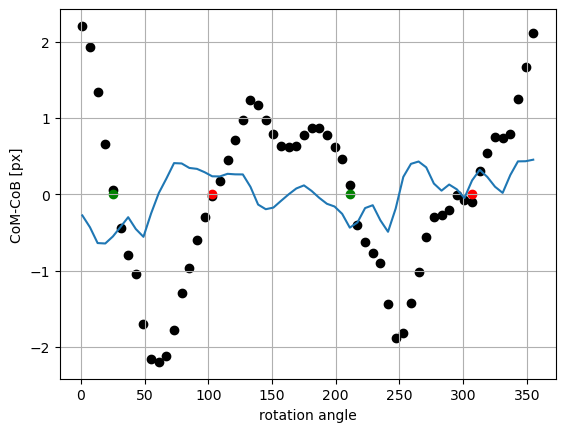

In [21]:
def rotate(point, origin, degrees):
    radians = np.deg2rad(degrees)
    x,y = point[:,0],point[:,1]
    offset_x, offset_y = origin
    adjusted_x = (x - offset_x)
    adjusted_y = (y - offset_y)
    cos_rad = np.cos(radians)
    sin_rad = np.sin(radians)
    qx = offset_x + cos_rad * adjusted_x + sin_rad * adjusted_y
    qy = offset_y + -sin_rad * adjusted_x + cos_rad * adjusted_y
    return np.vstack((qx, qy)).T

plt.figure()
contour = np.genfromtxt(contoursPATH[1],dtype='float',delimiter=',').T
contour[:,1 ] = -contour[:,1] + 3000 # straighten y direction

com,_ = hydrostasy(contour)
rotatedCont = rotate(contour,[com.x,com.y],30)
plt.plot(contour[:,0],contour[:,1],label='orig')
plt.plot(rotatedCont[:,0],rotatedCont[:,1],label='rotated')
del com

com,cob = hydrostasy(rotatedCont)
plt.scatter(com.x,com.y,label='CoM')
plt.scatter(cob.x,cob.y,label='CoB')
print(f'x-location difference CoM-CoB = {com.x-cob.x:.2f} px')

plt.legend(loc='upper right')
plt.gca().set_aspect('equal')
plt.show()

plt.figure()
angleStep = 6
stability = np.zeros((int(360/angleStep),2))

for i,angle in enumerate(np.arange(1,360,angleStep)):
    contour = np.genfromtxt(contoursPATH[1],dtype='float',delimiter=',').T
    contour[:,1 ] = -contour[:,1] + 3000 # straighten y direction

    com,_ = hydrostasy(contour)
    rotatedCont = rotate(contour,[com.x,com.y],angle)
    del com
    com,cob = hydrostasy(rotatedCont)
    stability[i] = angle, com.x-cob.x

plt.scatter(stability[:,0],stability[:,1],c='k')
zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
index_zc = stability[zero_crossings,0]
# plt.scatter(index_zc,np.zeros_like(index_zc),c='red')
plt.plot(stability[:,0],np.gradient(stability[:,1]))
unstablePointsAngles = []
for i in zero_crossings:
    if np.gradient(stability[:,1])[i]<0:
        plt.scatter(stability[i,0],0,c='green')
    else:
        plt.scatter(stability[i,0],0,c='red')
        unstablePointsAngles.append(stability[i,0])

print(f'Stability index = {360-unstablePointsAngles[-1]+unstablePointsAngles[0]} degrees')

plt.ylabel('CoM-CoB [px]')
plt.xlabel('rotation angle')
plt.grid()
plt.show()

### Apply to all contours

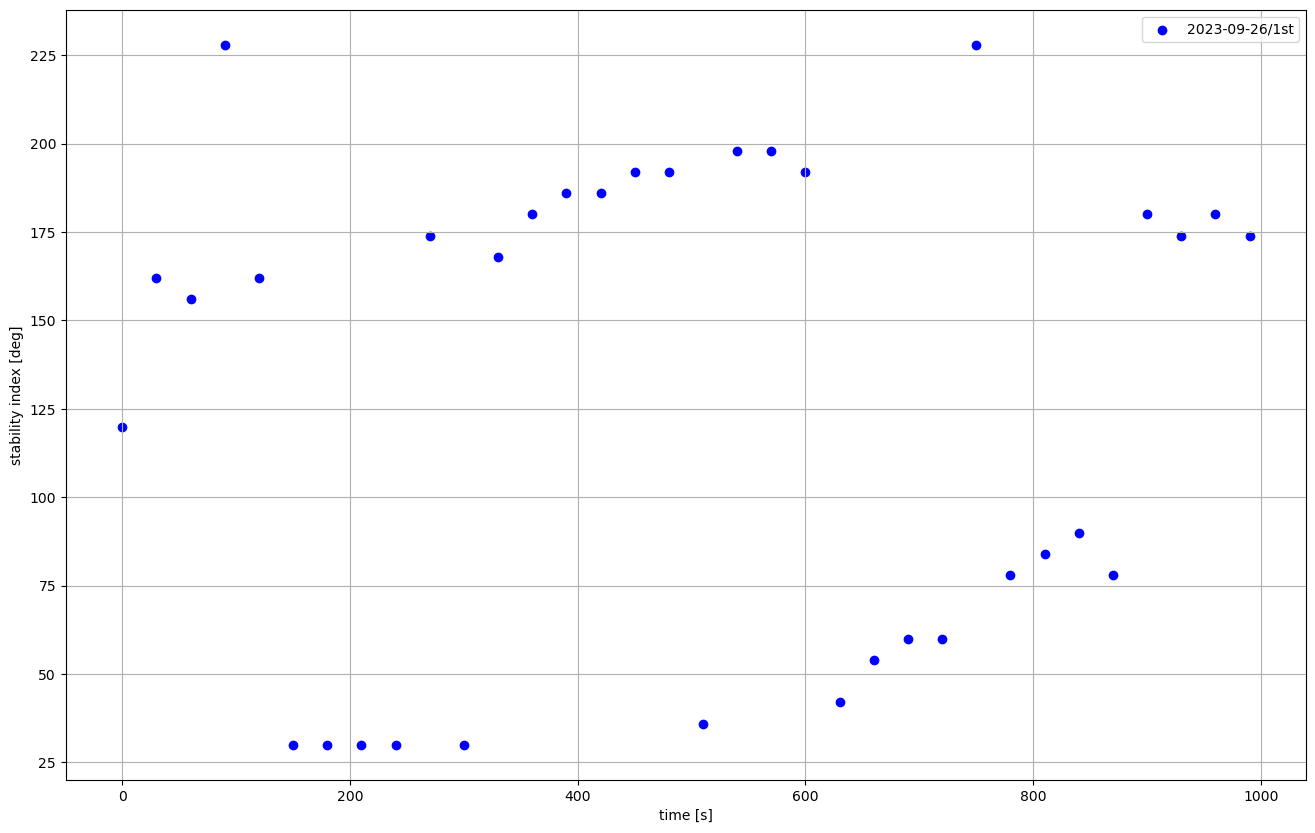

In [86]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-26/1st']

plt.figure(figsize=(16,10))

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        contour[:,1 ] = -contour[:,1] + 4000 # straighten y direction
        
        angleStep = 6
        stability = np.zeros((int(360/angleStep),2))

        for i,angle in enumerate(np.arange(1,360,angleStep)):
            com,_ = hydrostasy(contour,densityRatio=917/1005) ### CHANGE SALTY OR FRESH
            rotatedCont = rotate(contour,[com.x,com.y],angle)
            del com
            com,cob = hydrostasy(rotatedCont,densityRatio=917/1005)  ### CHANGE SALTY OR FRESH
            stability[i] = angle, com.x-cob.x

        zero_crossings = np.where(np.diff(np.sign(stability[:,1])))[0]
        index_zc = stability[zero_crossings,0]
        unstablePointsAngles = []
        for i in zero_crossings:
            if np.gradient(stability[:,1])[i]>0:
                unstablePointsAngles.append(stability[i,0])

        # print(f'Stability index = {360-unstablePointsAngles[-1]+unstablePointsAngles[0]} degrees')
        if ic ==0:
            if it==0:
                plt.scatter(30*it,360-unstablePointsAngles[-1]+unstablePointsAngles[0],c='blue',label=cylinder)
            else:
                plt.scatter(30*it,360-unstablePointsAngles[-1]+unstablePointsAngles[0],c='blue')
        elif ic ==1:
            if it==0:
                plt.scatter(30*it,360-unstablePointsAngles[-1]+unstablePointsAngles[0],c='red',label=cylinder)
            else:
                plt.scatter(30*it,360-unstablePointsAngles[-1]+unstablePointsAngles[0],c='red')

# draw rotation lines
# for t in [12,28,42,63,69,81,96,113,131,150]:
#    plt.vlines(t*10,25,375,colors='blue')

plt.xlabel('time [s]')
plt.ylabel('stability index [deg]')
plt.grid()
plt.legend()
plt.show()


# Temperature penetration

/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_85791/129687285.py:28: RuntimeWarning: divide by zero encountered in true_divide
  T_star = -8 + 8 * erf(r/np.sqrt(alpha*t))
/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_85791/129687285.py:33: RuntimeWarning: invalid value encountered in double_scalars
  -8 + 8 * erf(coord/np.sqrt(alpha*t)), # change according to the T_star definition


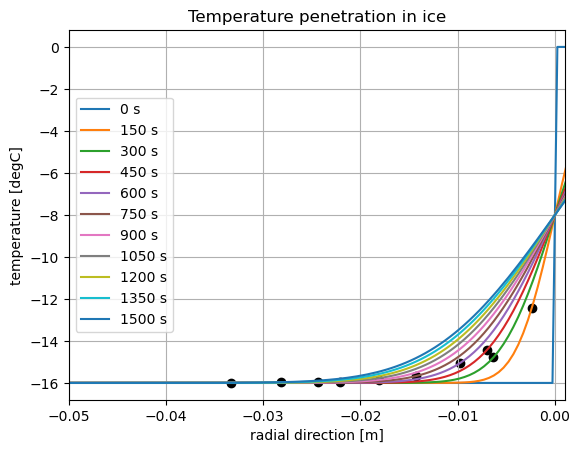

In [291]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-14/'
cylinders = ['1st']

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)

    radii = []
    for contourPATH in contoursPATH:
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',').T
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
        radii.append(radius)

h = 0.0405
r = np.linspace(-0.05,.05,200)
convert = radii[0]/.0405

plt.figure()

for it in np.arange(len(radii))[::5]:
    t = 30*it
    # T_star = 2 + 18 * erf(r/np.sqrt(alpha*t)) # in case of contact with water at 20 deg
    T_star = -8 + 8 * erf(r/np.sqrt(alpha*t))
    plt.plot(r,T_star,label=str(int(t))+' s')
    coord = +radii[it]/convert - 0.0405
    # plt.vlines(coord,-16,20,linestyles='--',colors='grey')
    plt.scatter(coord,
                -8 + 8 * erf(coord/np.sqrt(alpha*t)), # change according to the T_star definition
                c='k',marker='o')

plt.grid()
plt.legend(loc='center left')
plt.xlabel('radial direction [m]')
plt.ylabel('temperature [degC]')
plt.title('Temperature penetration in ice')
plt.xlim(-.05,0.001)
plt.show()

In [278]:
radii[0] 

984.8083349151398